<a href="https://colab.research.google.com/github/vojtam/NLP-with-Transformers/blob/main/02_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2. Text Classification

In [2]:
%%capture

!pip install datasets
!pip install umap-learn


In [3]:
import torch

i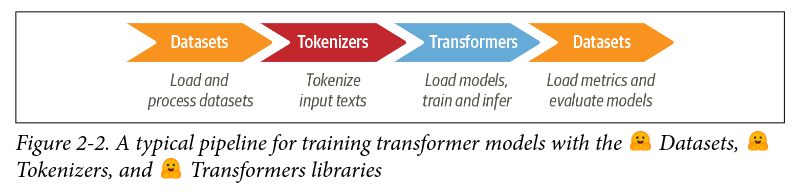

## HuggingFace Datasets

### Load dataset

In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

The structure is basically a dictionary where each key corresponds to a different split.

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

each row is represented as a dictionary, where the keys correspond to the column names

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

## From Datasets to DataFrames

In [10]:
import pandas as pd
emotions.set_format(type = "pandas")
df = emotions['train'][:]

In [11]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


#### Convert numerical labels to textual

we will create a function that takes in a single row of the DF (which means we can use apply on the whole dataset and apply the function on every row)

In [12]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)

In [13]:
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Data exploration

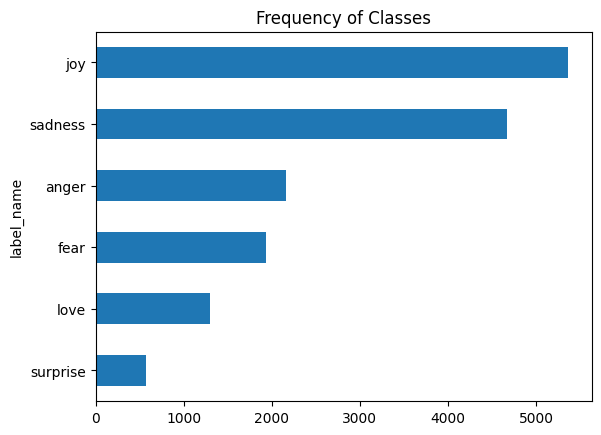

In [14]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending = True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

The same plot with seaborn

note that there is no ascending = True logic in seaborn, it is up to the user to provide the exact ordering

Text(0.5, 1.0, 'Frequency of Classes')

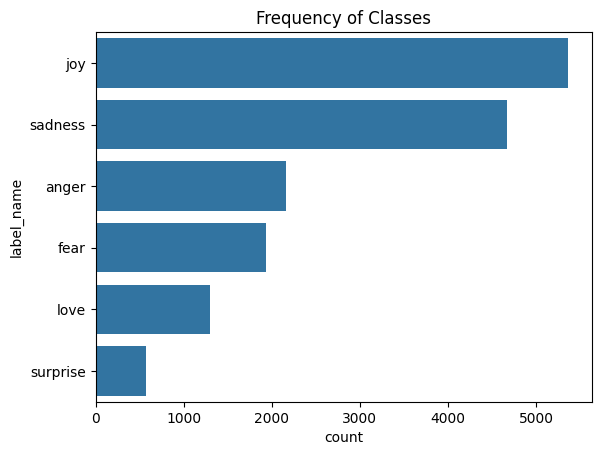

In [15]:
import seaborn as sns
sns.countplot(data = df, y = 'label_name', order = df['label_name'].value_counts().index)
plt.title('Frequency of Classes')

#### How long are the tweets?

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='label_name', ylabel='words_per_tweet'>

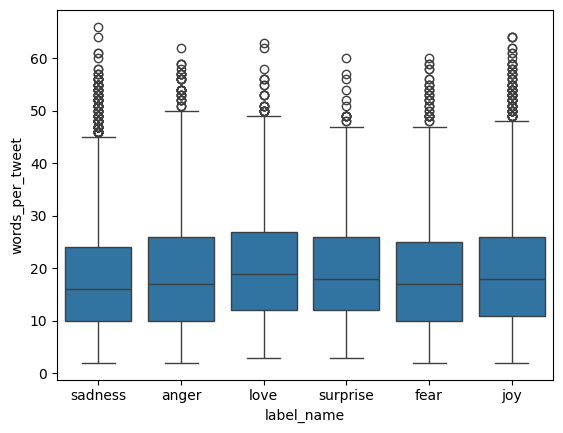

In [16]:
df["words_per_tweet"] = df['text'].str.split().apply(len)
sns.boxplot(data = df, x = 'label_name', y = 'words_per_tweet')

## From Text to Tokens



### Word Tokenization

We can split the words and map each word to a unique integer.

In [17]:
emotions.reset_format()

In [18]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = text.split()
tokenized_text

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']

In [19]:
token2idx = {word: idx for idx, word in enumerate(sorted(set(tokenized_text)))}
token2idx

{'NLP.': 0,
 'Tokenizing': 1,
 'a': 2,
 'core': 3,
 'is': 4,
 'of': 5,
 'task': 6,
 'text': 7}

### Subword Tokenization

In [20]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

we can see that all the words have been mapped to unique integers.

We can convert the ids back into tokens with `convert_ids_to_tokens()` method

In [22]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

We can also convert the tokens back to the original string with the `convert_tokens_to_string()` method:

In [23]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

We can also inspect several useful attributes of the tokenizer, such as:
- vocabulary size
- maximum context size of the corresponding model
- the fields that the model expects in the forward pass

In [24]:
tokenizer.vocab_size

30522

In [25]:
tokenizer.model_max_length

512

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']


### Tokenizing the whole dataset

In [27]:

def tokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)


This function applies the tokenizer logic to each text field of the batch of examples
- `padding = True` will pad the examples with 0 token id up to the size of the longest example in the batch => all examples will have the same length
- `truncation = True` will truncate the examples to the size of the model's maximum context size

In [28]:
tokenize(emotions['train'][:5])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [29]:
emotions['train'][:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

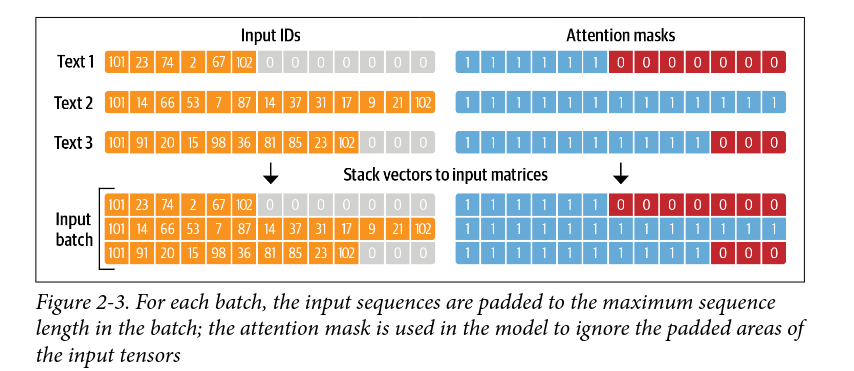

We can see that the examples are tokenized to the length of the second (longest) example

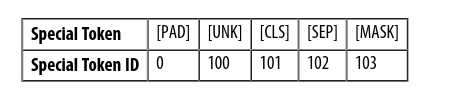

Table of the special tokens

In [60]:
# tokenize the whole dataset

emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)
# since we set batch_size = None, the whole dataset is treated as a single batch

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [61]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Training a Text Classifier

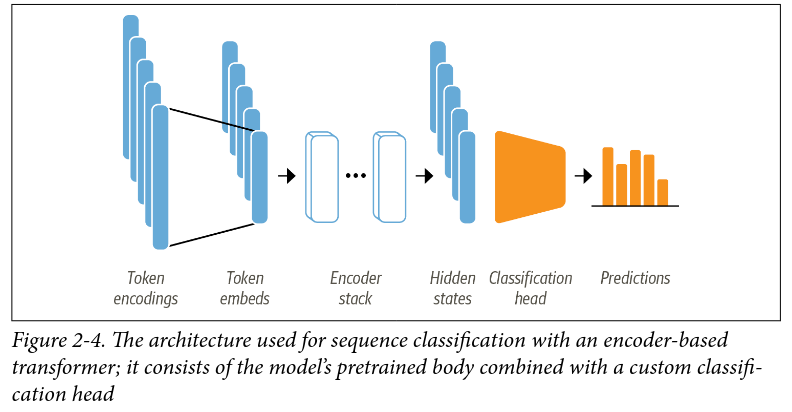

### Transformers as Feature Extractors

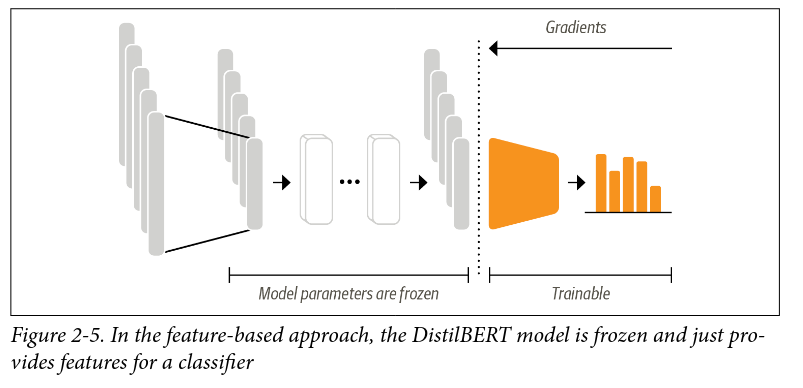

In [62]:
from transformers import AutoModel

model_checkpoint = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_checkpoint).to(device)

#### Extracting the last hidden state

In [63]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt").to(device)
inputs['input_ids'].shape


torch.Size([1, 6])

The sahpe is `[batch_size, n_tokens]`

In [64]:
inputs = {key : value.to(device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

In [65]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

The `**` operator unpacks the dictionary `inputs` into keyword arguments.

The keys of the dictionary (`input_ids`, `attention_mask`) become the names of the arguments, and the values become the values of the arguments

This is equivalent to calling:

`outputs = model(input_ids=inputs['input_ids'], attention_mask=input['attention_mask'])`

In [66]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [67]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

The shape is `[batch_size, n_tokens, hidden_dim]` so for each of the 6 input tokens, we get 768-dimensional tensor (vector).

For classification, it is customary to work with the last hidden state of the first token - the `[CLS]` token as it naturally represents the whole input sequence

In [68]:
CLS_last_hidden_state = outputs.last_hidden_state[:, 0]

the `:` here selects all batches, and the index `0` selects the first token - `[CLS]` token, returning tensor of shape `[1, 768]`

In [69]:
CLS_last_hidden_state.shape

torch.Size([1, 768])

Let's write a function that selects the last hidden state of the CLS token for every example in our dataset

In [70]:
def extract_hidden_state(batch):
    inputs = {key : value.to(device) for key, value in batch.items() if key in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # return the vector for [CLS] token
    return {'hidden_state' : last_hidden_state[:, 0].cpu().numpy()}


the model expects tensors -> convert the columns to torch from numpy

In [71]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

Now we can extract all hidden states across the dataset

In [72]:
emotions_hidden_states = emotions_encoded.map(extract_hidden_state, batched=True, batch_size=1000)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [73]:
emotions_hidden_states

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

so now we have computed the hidden state for each example (tweet) in the dataset. -> we can train our classifier

In [74]:
emotions_hidden_states['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

### Generating a feature matrix and the splits

we will use the hidden states as the input features and the labels as targets. To create the splits, we will go along with the classic Scikit-learn syntax

In [75]:
import numpy as np

In [76]:
X_train = np.array(emotions_hidden_states['train']['hidden_state'])
X_valid = np.array(emotions_hidden_states['validation']['hidden_state'])
y_train = np.array(emotions_hidden_states['train']['label'])
y_valid = np.array(emotions_hidden_states['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualize the training set (hidden states) with UMAP

Visualizing 768 dimensions is not feasible. But we can use UMAP to project the vectors to 2 dimensions. UMAP expects the features to be in `[0, 1]` interval -> we will use sklearn's MinMaxScaler

In [77]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [78]:
# scale features to [0, 1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# fit UMAP
mapper = UMAP(n_components = 2, metric = 'cosine').fit(X_train_scaled)

# create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()


,X,Y,label
0,4.287539,6.444595,0
1,-3.156860,5.687406,0
2,5.436463,2.951744,3
3,-2.548712,3.712987,2
4,-3.447035,3.820462,3


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

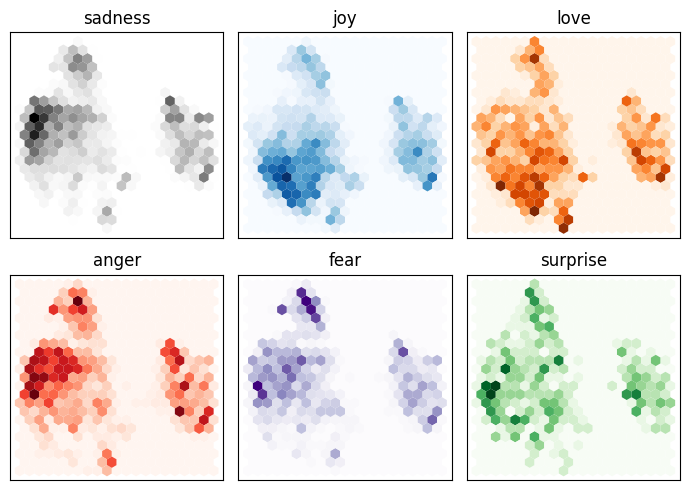

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap = cmap, gridsize = 20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt

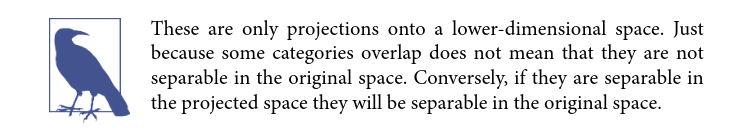

we can see that positive emotions occupy roughly the same space. The same can be said for the negative emotions. Surprise is kinda all over the place

### Training a simple classifier

In [80]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(max_iter=3000)
lr_classifier.fit(X_train, y_train)
lr_classifier.score(X_valid, y_valid)

0.635

Let's compare this result with a simple baseline that always selects the majority class.

In [81]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.score(X_valid, y_valid)

0.352

Let's look at the confusion matrix to see how our classifier is doing.

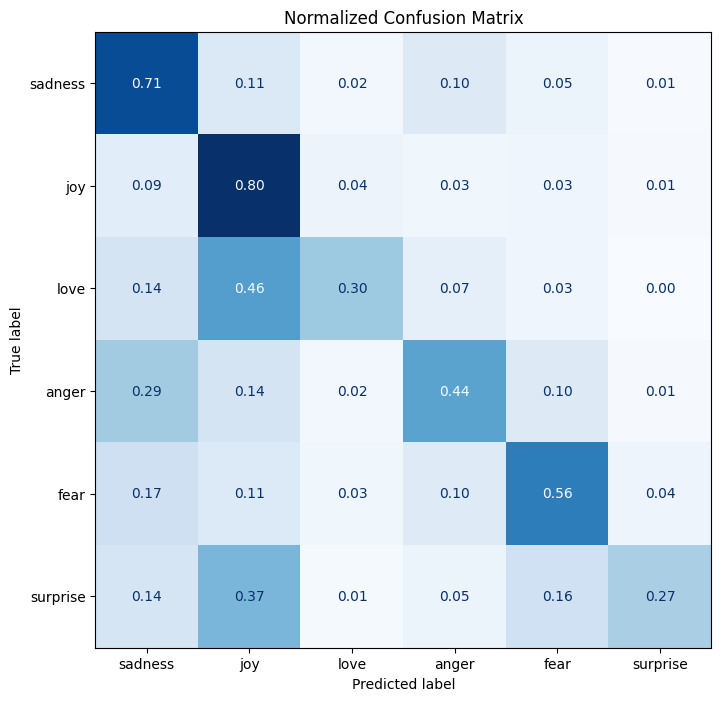

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    conf_matrix = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap = 'Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

y_preds = lr_classifier.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

## Fine-Tuning Transformers

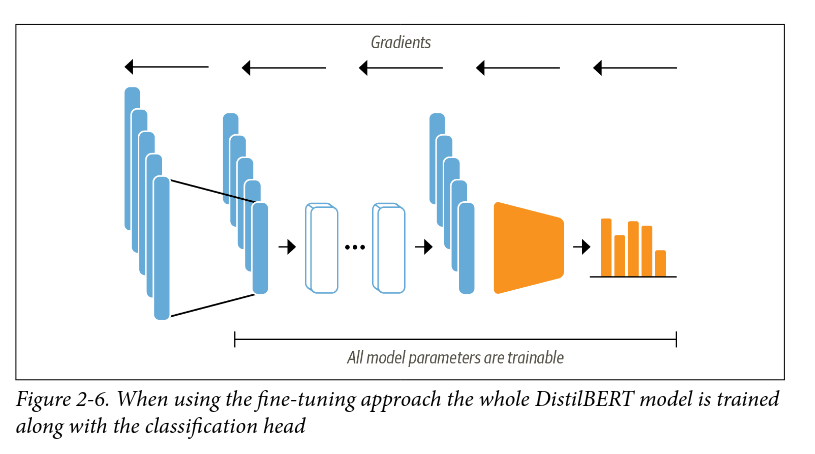

In [104]:
from transformers import AutoModelForSequenceClassification

In [105]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels).to(device))

In [42]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [45]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
from transformers import Trainer, TrainingArguments

batch_size = 64

logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_checkpoint}-finetuned-emotion'
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 5,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = 'error')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
trainer = Trainer(model = model, args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded['train'],
                  eval_dataset = emotions_encoded['validation'],
                  tokenizer = tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.783900,0.264227,0.915000,0.915525
2,0.198600,0.173024,0.933000,0.932795
3,0.135200,0.146749,0.939500,0.939877
4,0.106800,0.137514,0.937500,0.937602
5,0.089900,0.140771,0.939000,0.938997


TrainOutput(global_step=1250, training_loss=0.2628644515991211, metrics={'train_runtime': 595.3435, 'train_samples_per_second': 134.376, 'train_steps_per_second': 2.1, 'total_flos': 1800857154240000.0, 'train_loss': 0.2628644515991211, 'epoch': 5.0})

In [50]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

{'test_loss': 0.14077143371105194,
 'test_accuracy': 0.939,
 'test_f1': 0.9389974574415196,
 'test_runtime': 4.5656,
 'test_samples_per_second': 438.058,
 'test_steps_per_second': 7.009}

In [53]:
preds_output.predictions.shape

(2000, 6)

In [83]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

In [84]:
y_preds

array([0, 0, 2, ..., 1, 1, 1])

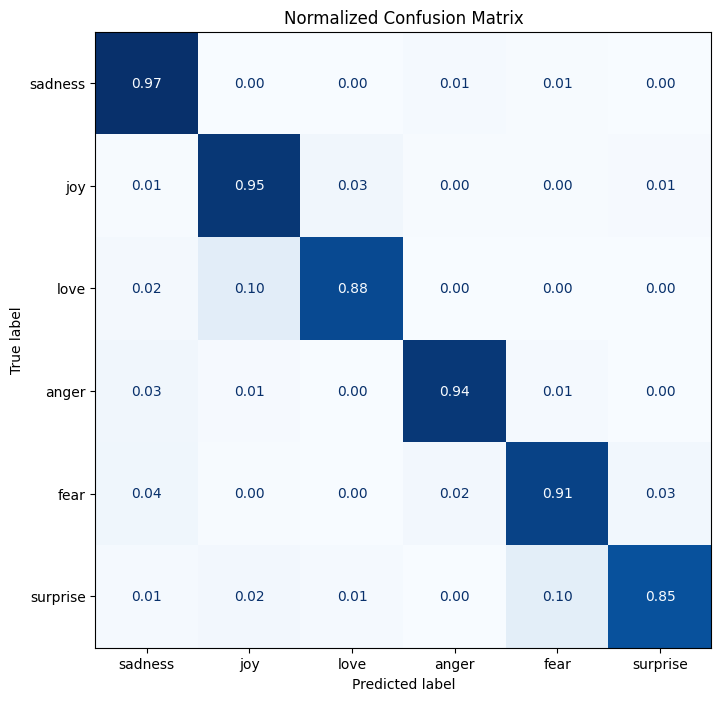

In [85]:
plot_confusion_matrix(y_preds, y_valid, labels)

looks actually really good.

## Error analysis

In [86]:
from torch.nn.functional import cross_entropy

In [106]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [107]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [108]:
# compute loss values
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_labels, batched = True, batch_size = 16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [109]:
emotions_encoded['validation']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [111]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']

df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)


df_test.sort_values('loss', ascending = True).head(10)

,text,label,predicted_label,loss
985,i live in between my moments of sun sometimes ...,sadness,sadness,1.556759
1070,i feel sort of helpless,sadness,sadness,1.566756
870,i can feel my brain aching from the intense co...,sadness,sadness,1.578730
1585,i just wanted the dark of night to swallow me ...,sadness,sadness,1.578987
1027,i hate this feeling of helpless,sadness,sadness,1.579137
1726,i suffer this kind of exhaustion i feel useless,sadness,sadness,1.580415
1713,i just feel gassed and low energy,sadness,sadness,1.580712
1399,i know what a car feels like when its running ...,sadness,sadness,1.581936
115,i went from feeling helpless to powerful,sadness,sadness,1.582174
393,i drew this because i feel hated,sadness,sadness,1.583505


## Saving and sharing the model

In [112]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1727961668.573d447df849.1216.0:   0%|          | 0.00/8.38k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vojtam/distilbert-base-uncased-finetuned-emotion/commit/0343fa8f49c53f7c8b76d7aaf5f087c8d23bdf4a', commit_message='Training completed!', commit_description='', oid='0343fa8f49c53f7c8b76d7aaf5f087c8d23bdf4a', pr_url=None, pr_revision=None, pr_num=None)

In [113]:
from transformers import pipeline

model_id = 'vojtam/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model = model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [114]:
tweet = "I saw a movie today and it was really good"
preds = classifier(tweet, return_all_scores = True)
preds

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.004065379034727812},
  {'label': 'LABEL_1', 'score': 0.9857780933380127},
  {'label': 'LABEL_2', 'score': 0.0012977749574929476},
  {'label': 'LABEL_3', 'score': 0.005704048555344343},
  {'label': 'LABEL_4', 'score': 0.0020121936686336994},
  {'label': 'LABEL_5', 'score': 0.0011424962431192398}]]

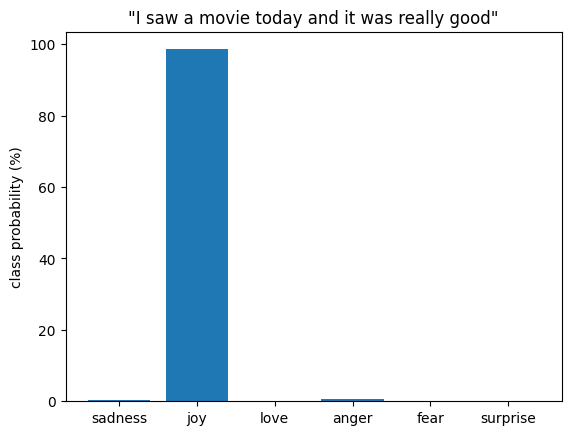

In [115]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'], color = 'C0')
plt.title(f'"{tweet}"')
plt.ylabel('class probability (%)')
plt.show()